In [29]:
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
from PIL import ImageFile
from sklearn.metrics import confusion_matrix, classification_report

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import InputLayer
from tensorflow.keras.layers import Input
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.regularizers import L1
from keras.regularizers import L2
from keras.regularizers import L1L2
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import decode_predictions
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model

In [30]:
pip install split-folders

In [31]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [32]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
!rm -rf ./logs/
tf.summary.create_file_writer("./logs/")

# Preprocessing

In [33]:
dataset_dir = '/content/gdrive/MyDrive/Skripsi Backup/Dataset/'

In [34]:
import os
from os import listdir
from PIL import Image
import PIL


directories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

for directory in directories:
  for filename in listdir(dataset_dir+directory+'/'):
    try:
      filepath = dataset_dir+directory+'/'+filename
      img = Image.open(filepath)
      _, ext = os.path.splitext(filepath)

      if ext.lower() not in ['.jpg', '.jpeg', '.png', '.crdownload']:
        raise ValueError(f"The file '{filepath}' is not a .jpg or .png file.")
    except PIL.UnidentifiedImageError as e:
      print(f"Error: {filename} is not a valid image file.")

In [35]:
for directory in directories:
  for filename in listdir(dataset_dir+directory+'/'):
    if filename.endswith(".webp"):
        webp_image = Image.open(os.path.join(dataset_dir+directory+'/', filename))
        rgb_image = webp_image.convert("RGB")
        new_filename = os.path.splitext(filename)[0] + ".jpg"
        rgb_image.save(os.path.join(dataset_dir+directory+'/', new_filename), "JPEG")
        rgb_image.close()
        os.remove(os.path.join(dataset_dir+directory+'/', filename))

In [36]:
import splitfolders
splitfolders.ratio(dataset_dir, output="datasets", seed=1414, ratio=(0.7, 0.2, 0.1))

Copying files: 2512 files [00:19, 127.58 files/s]


In [37]:
train_dir = 'datasets/train/'
val_dir = 'datasets/val/'
test_dir = 'datasets/test/'

In [38]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [39]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [40]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [41]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Found 1758 images belonging to 10 classes.


In [42]:
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Found 502 images belonging to 10 classes.


In [43]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Found 252 images belonging to 10 classes.


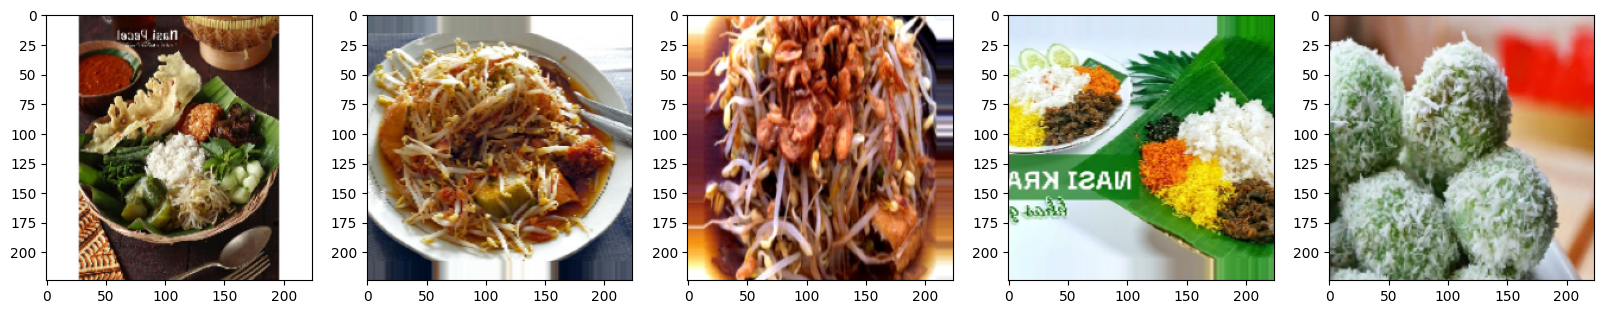

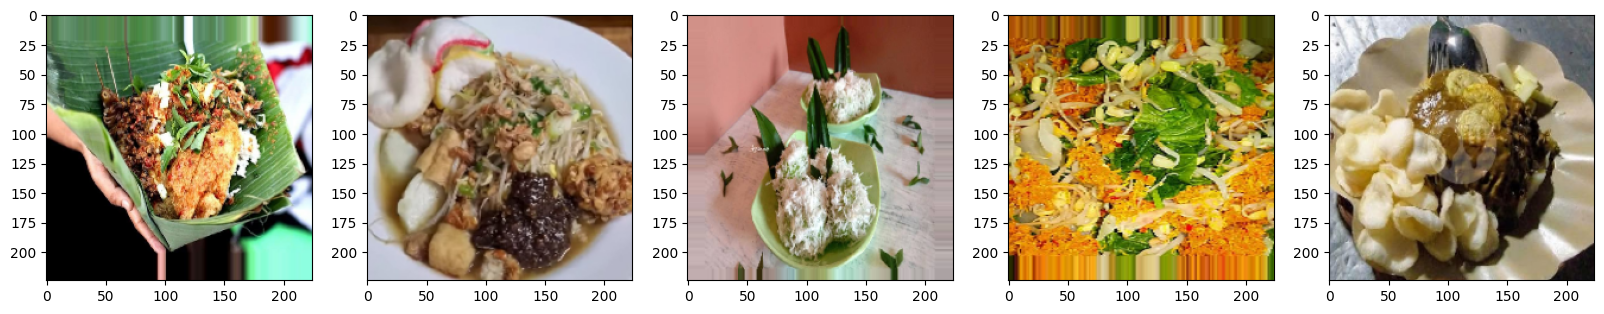

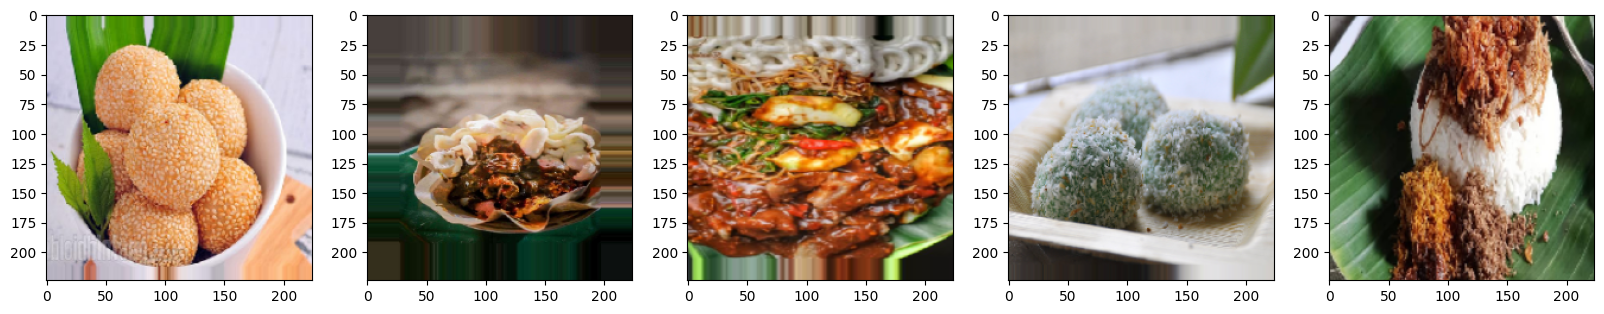

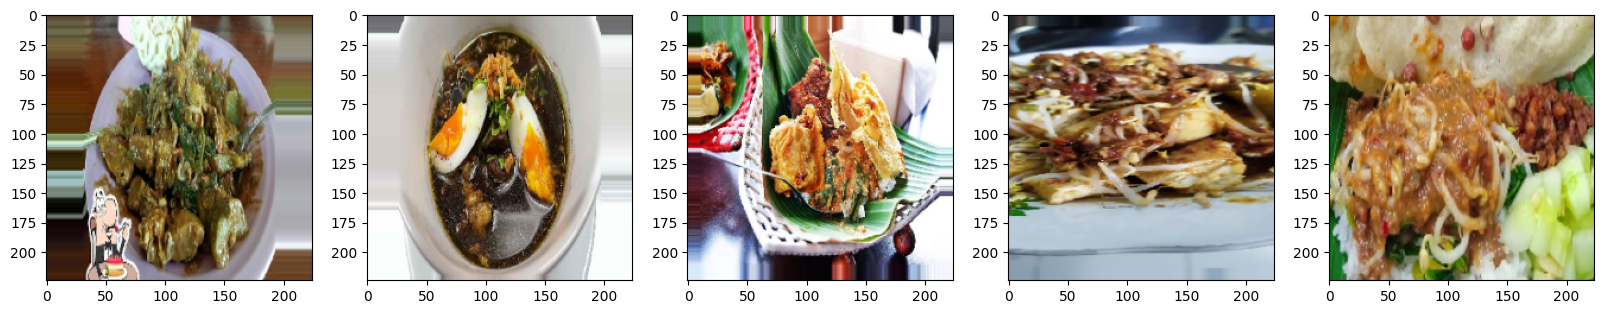

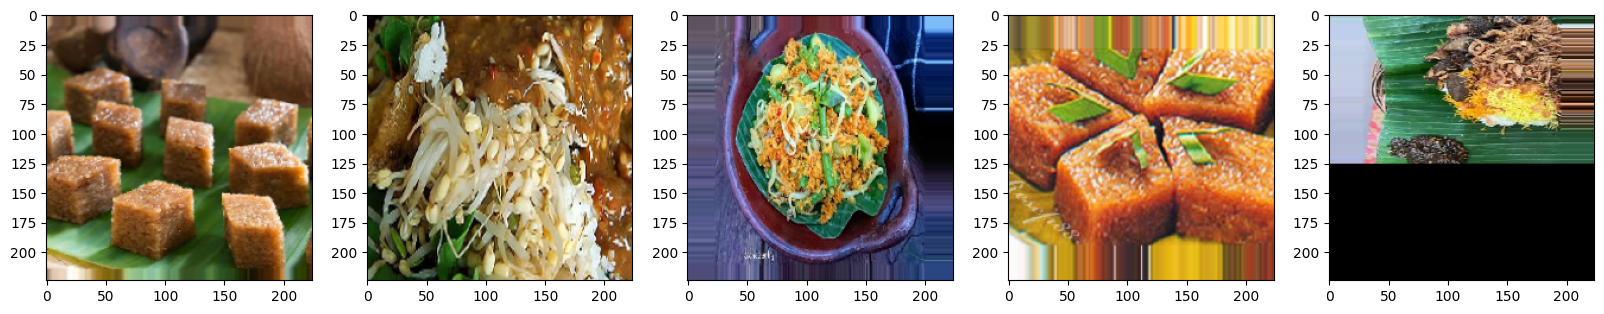

In [44]:
columns = 5
rows = 5

for i in range(columns):
    batch = train_generator.next()
    plt.figure(figsize=(20, 20))
    for j in range(rows):
        image = batch[0][j]
        plt.subplot(rows, columns, j + 1)  # Set up subplots for 2x2 display
        plt.imshow(image)
    plt.show()

# Modelling

In [45]:
input = Input(shape=(224, 224, 3))

In [46]:
classes = len(train_generator.class_indices)
base_model1 = MobileNetV3Large(
    alpha=0.75,
    minimalistic=False,
    include_top=False,
    input_tensor=input,
    pooling="max",
    dropout_rate=0.5,
    include_preprocessing=False,
)
base_model1.trainable = True

7929688/7929688 [==============================] - 0s 0us/step


In [47]:
model1 = Sequential([
    base_model1,
    Flatten(),
    Dense(classes, activation='softmax', activity_regularizer=L1L2(1e-4, 1e-4))
])

In [48]:
classes = len(train_generator.class_indices)
base_model2 = MobileNetV2(
    alpha=0.75,
    include_top=False,
    input_tensor=input,
    pooling="avg",
)
base_model2.trainable = True

In [49]:
model2 = Sequential([
    base_model2,
    Flatten(),
    Dense(classes, activation='softmax', activity_regularizer=L1L2(1e-3, 1e-3))
])

In [50]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 720)               1808736   
 al)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 720)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                7210      
                                                                 
Total params: 1815946 (6.93 MB)
Trainable params: 1796858 (6.85 MB)
Non-trainable params: 19088 (74.56 KB)
_________________________________________________________________


In [51]:
model2.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7f4ad20f8880>>

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.872368 to fit



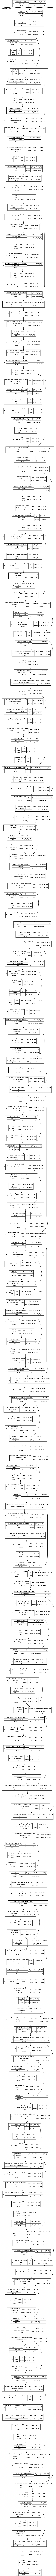

In [52]:
plot_model(
    model1,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

In [57]:
class AccuracyCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
       if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.92):
          self.model.stop_training = True

accuracy_callback = AccuracyCallback()

In [58]:
class BeuModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if self.epochs_since_last_save == 0:  # Save at the end of the epoch
            date_str = datetime.datetime.now().strftime("%Y-%m-%d")
            accuracy = logs.get('accuracy')  # Assuming accuracy is available in logs
            if accuracy is not None:
                folder_name = date_str
                if not os.path.exists(folder_name):
                    os.makedirs(folder_name)
                new_filename = os.path.join(folder_name, f"beu_model_{accuracy:.4f}.h5")
                os.rename(self.filepath, new_filename)
                self.filepath = new_filename

checkpoint_path = "beu_model.h5"
checkpoint_callback = BeuModelCheckpoint(filepath=checkpoint_path, save_weights_only=False, save_freq='epoch', period=10)

In [59]:
model1.compile(
    optimizer = tf.optimizers.Adam(learning_rate=1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [60]:
history = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=125,
    verbose=2,
    callbacks=[accuracy_callback, checkpoint_callback]
)

Epoch 1/125
55/55 - 68s - loss: 4.0338 - accuracy: 0.2986 - val_loss: 3.5106 - val_accuracy: 0.3287 - 68s/epoch - 1s/step
Epoch 2/125
55/55 - 39s - loss: 2.4826 - accuracy: 0.4915 - val_loss: 2.7270 - val_accuracy: 0.4562 - 39s/epoch - 704ms/step
Epoch 3/125
55/55 - 38s - loss: 1.6657 - accuracy: 0.5995 - val_loss: 2.3575 - val_accuracy: 0.5020 - 38s/epoch - 696ms/step
Epoch 4/125
55/55 - 38s - loss: 1.2323 - accuracy: 0.6843 - val_loss: 1.9095 - val_accuracy: 0.5817 - 38s/epoch - 688ms/step
Epoch 5/125
55/55 - 36s - loss: 0.9815 - accuracy: 0.7594 - val_loss: 1.8153 - val_accuracy: 0.5936 - 36s/epoch - 649ms/step
Epoch 6/125
55/55 - 37s - loss: 0.7416 - accuracy: 0.7861 - val_loss: 1.5353 - val_accuracy: 0.6633 - 37s/epoch - 665ms/step
Epoch 7/125
55/55 - 37s - loss: 0.6285 - accuracy: 0.8140 - val_loss: 1.4507 - val_accuracy: 0.6673 - 37s/epoch - 669ms/step
Epoch 8/125
55/55 - 36s - loss: 0.5312 - accuracy: 0.8430 - val_loss: 1.2192 - val_accuracy: 0.7211 - 36s/epoch - 660ms/step
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 - 38s - loss: 0.3499 - accuracy: 0.8800 - val_loss: 1.2075 - val_accuracy: 0.7331 - 38s/epoch - 689ms/step
Epoch 11/125
55/55 - 37s - loss: 0.3415 - accuracy: 0.8936 - val_loss: 1.0623 - val_accuracy: 0.7450 - 37s/epoch - 673ms/step
Epoch 12/125
55/55 - 38s - loss: 0.3400 - accuracy: 0.8942 - val_loss: 1.0081 - val_accuracy: 0.7629 - 38s/epoch - 693ms/step
Epoch 13/125
55/55 - 36s - loss: 0.2854 - accuracy: 0.9010 - val_loss: 0.9642 - val_accuracy: 0.7829 - 36s/epoch - 646ms/step
Epoch 14/125
55/55 - 37s - loss: 0.2378 - accuracy: 0.9278 - val_loss: 0.9484 - val_accuracy: 0.7849 - 37s/epoch - 676ms/step
Epoch 15/125
55/55 - 37s - loss: 0.2171 - accuracy: 0.9278 - val_loss: 0.8854 - val_accuracy: 0.8028 - 37s/epoch - 664ms/step
Epoch 16/125
55/55 - 36s - loss: 0.1821 - accuracy: 0.9369 - val_loss: 0.8281 - val_accuracy: 0.8267 - 36s/epoch - 654ms/step
Epoch 17/125
55/55 - 39s - loss: 0.1844 - accuracy: 0.9391 - val_loss: 0.7345 - val_accuracy: 0.8307 - 39s/epoch - 704ms/step
Epoch

# Evaluation

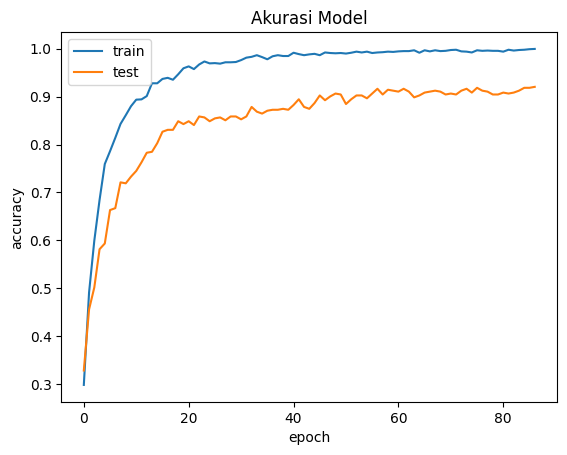

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

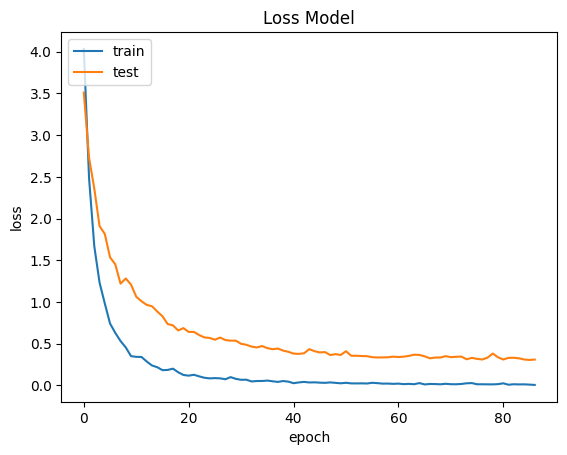

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

8/8 [==============================] - 3s 398ms/step - loss: 0.4556 - accuracy: 0.9167


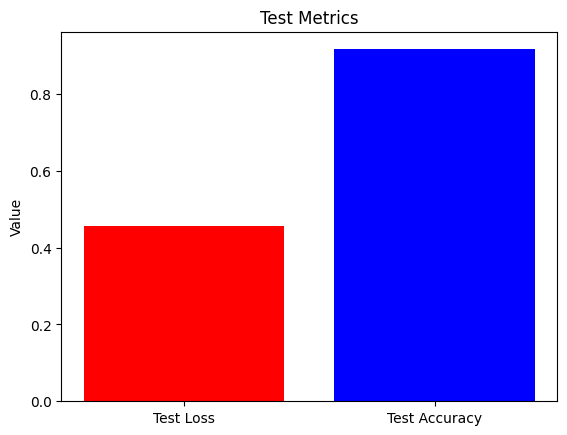

In [63]:
test_loss, test_accuracy = model1.evaluate(test_generator)

metrics = ['Test Loss', 'Test Accuracy']
values = [test_loss, test_accuracy]

plt.bar(metrics, values, color=['red', 'blue'])
plt.title('Test Metrics')
plt.ylabel('Value')
plt.show()

8/8 [==============================] - 3s 210ms/step


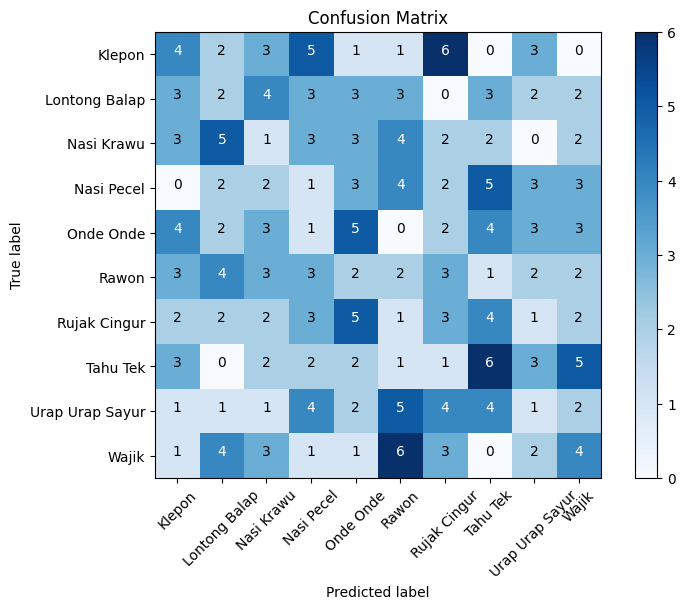

In [64]:
predictions = model1.predict(test_generator)
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)
class_names = list(train_generator.class_indices.keys())

cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()

# Display the values on the heatmap
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [65]:
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

                 precision    recall  f1-score   support

         Klepon       0.17      0.16      0.16        25
  Lontong Balap       0.08      0.08      0.08        25
     Nasi Krawu       0.04      0.04      0.04        25
     Nasi Pecel       0.04      0.04      0.04        25
      Onde Onde       0.19      0.19      0.19        27
          Rawon       0.07      0.08      0.08        25
   Rujak Cingur       0.12      0.12      0.12        25
       Tahu Tek       0.21      0.24      0.22        25
Urap Urap Sayur       0.05      0.04      0.04        25
          Wajik       0.16      0.16      0.16        25

       accuracy                           0.12       252
      macro avg       0.11      0.11      0.11       252
   weighted avg       0.11      0.12      0.11       252



In [67]:
# Save model for continued training
model1.save("beu_model")

# Convert to TFLite format
converter = tf.lite.TFLiteConverter.from_saved_model("beu_model")
tflite_model = converter.convert()

# Save the TFLite model to file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

